# Latency and capacity estimation for a network connection from asymmetric measurements

In [65]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import urllib
import os

## First data set

In [66]:
url = 'http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz'
urllib.request.urlretrieve(url, '/tmp/liglab2.log.gz')
os.system('gunzip /tmp/liglab2.log.gz')
os.system('sed -e "s/\[/ /"  -e "s/]/,/" -e "s/bytes.*time=/,/" -e "s/ms/ /" /tmp/liglab2.log > /tmp/ping_campus.log')
raw_data = pd.read_table("/tmp/ping_campus.log", header=None, sep=',', engine='python')

In [67]:
raw_data.columns = ['time', 'bytes','transmission_time']
raw_data

,time,bytes,transmission_time
0,1.421762e+09,665,22.50
1,1.421762e+09,1373,21.20
2,1.421762e+09,262,21.20
3,1.421762e+09,1107,23.30
4,1.421762e+09,1128,1.41
...,...,...,...
44408,1.421771e+09,1338,1.47
44409,1.421771e+09,1515,7.02
44410,1.421771e+09,1875,2.33
44411,1.421771e+09,1006,1.61


We will now look if we have missing data

In [68]:
raw_data[raw_data.isnull().any(axis=1)]

,time,bytes,transmission_time
12,1.421762e+09,21 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
116,1.421762e+09,9 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
314,1.421762e+09,9 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
508,1.421762e+09,9 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
590,1.421762e+09,18 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
...,...,...,...
43730,1.421771e+09,14 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
43985,1.421771e+09,12 bytes from lig-publig.imag.fr (129.88.11.7...,NaN
44024,1.421771e+09,8 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN
44170,1.421771e+09,8 bytes from lig-publig.imag.fr (129.88.11.7)...,NaN


We can see that we have 337 lines where the transmission time is missing. We will then delete them.

In [69]:
data = raw_data.dropna().copy()
data = data.reset_index(drop = True)
data

,time,bytes,transmission_time
0,1.421762e+09,665,22.50
1,1.421762e+09,1373,21.20
2,1.421762e+09,262,21.20
3,1.421762e+09,1107,23.30
4,1.421762e+09,1128,1.41
...,...,...,...
44031,1.421771e+09,1338,1.47
44032,1.421771e+09,1515,7.02
44033,1.421771e+09,1875,2.33
44034,1.421771e+09,1006,1.61


We need convert the date and time in float to use them.

In [70]:
data['time'] = data['time'].astype(float)
data['transmission_time'] = data['transmission_time'].astype(float)
data['bytes'] = data['bytes'].astype(int)
data

,time,bytes,transmission_time
0,1.421762e+09,665,22.50
1,1.421762e+09,1373,21.20
2,1.421762e+09,262,21.20
3,1.421762e+09,1107,23.30
4,1.421762e+09,1128,1.41
...,...,...,...
44031,1.421771e+09,1338,1.47
44032,1.421771e+09,1515,7.02
44033,1.421771e+09,1875,2.33
44034,1.421771e+09,1006,1.61


### Question 1/

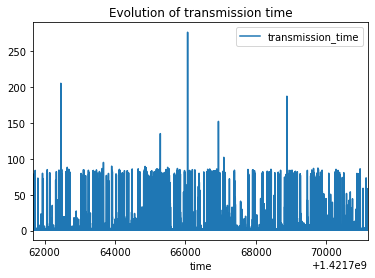

In [71]:
data.plot(x='time', y='transmission_time', title="Evolution of transmission time")

This is not really readable. We will take a different time scale to have a better view of the data.

In [72]:
(data['time'][44035] - data['time'][0]) / 3600

2.6402189027600818

The difference time between the first byte sent and the last one is about 2,6 hours. We will plot only the first quarter of the data to see what it looks like.

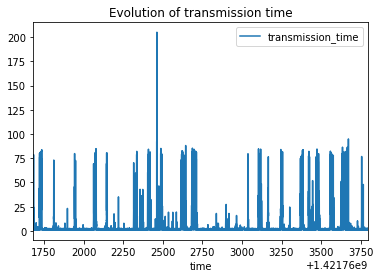

In [73]:
data[0:10000].plot(x='time', y='transmission_time', title="Evolution of transmission time")

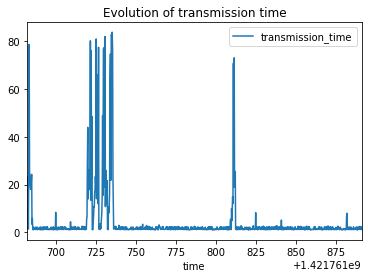

In [74]:
data[0:1000].plot(x='time', y='transmission_time', title="Evolution of transmission time")

We can not say yet why we have this kind of graphic. Is the variations of time only depend on the size of the packet? To answer, we need to continue our analysis.

### Question 2/

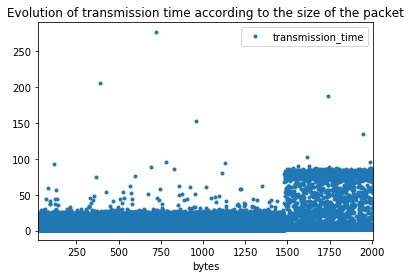

In [76]:
data.plot(x='bytes', y='transmission_time', title="Evolution of transmission time according to the size of the packet", style='.')

We observe a "disruption" when the packet size is more than 1500 bytes. For packets whose size is between 0 and 1500 bytes, the transmission time is more or less between 0 and 2,5 ms. But when the size of the packets is bigger than 1500 bytes, the transmission time could reach at least 8,5 ms.

### Question 3/

If we zoom, we can see that the limitation between the two part is more at 1480 bytes. We will take this value for the next question.